# Técnicas de Monte Carlo

Otra técnica de MC es la llamada cuadratura de MC.

$$I = \int f(x)dV \approx V \left< f\right>= \frac{V}{N}\sum_{i=0}^{N-1} f(x_i) \pm V\sqrt{\frac{\left< f^2\right>-\left< f\right>^2}{N}}$$

donde $V$ es el volumen te integración y los numeros $x_i$ son generados aleatoriamente con distribución uniforme en el rango de la funcíon $f(x)$.

## Importance Sampling (IS)

El uso de técnnicas de Monte Carlo se vuelve más atractiva cuando la estrategia de muestreo de importancia es implementado. Una de las desventajas para implementar dicha estrategia, es que uno necesita tener información sobre la función, pero uno es recompensado con una precisión mucho mayor.
Es más sencillo ilustrar la idea en 1D. Si se sabe que la función $f(x)$ a integrar es mayormente proporcional a otra función $w(x)$ en la región donde la integral contiene la mayor parte del peso, es posible  reescribir la integral así

$$I = \int f(x)dx=\int\frac{f(x)}{w(x)}w(x)dx$$

Donde la funcion de peso $w(x)$ debe cumplir que 
- $w(x)~>~0~\forall~x$
- $\int w(x)dx=1$

Entonces se puede definir $ W(s)=\int^{x}w(t)dt $ tal que $ dW(x)=w(x)dx $, que nos permite reescribir la integral original como

$$I = \int f(x)dx = \int\frac{f(x(W))}{w(x(W))}dW \longrightarrow \left\langle \frac{f(x(W))}{w(x(W))} \right\rangle _{W} $$

Esto es 
$$I\approx \frac{1}{N}\sum_i^N{\frac{f(W^{-1}(r_i))}{w(W^{-1}(r_i))}}$$

Si la función $f/w$ en la malla $W$ es razonablemente plana, MC puede integrarla de manera eficiente. El error ahora es proporcional a $\sqrt{\frac{\left\langle (f/w)^2 \right\rangle-\left\langle f/w \right\rangle^2}{N}}$ , por lo tanto, es considerablemente reducido respecto al MC normal.

Para implementar el algoritmo, generamos números aleatorios uniformes $r$ en el intervalo $r \in [0, 1]$ que corresponden a la variable $W$. Podemos resolver la ecuación para $x = W^{− 1}(r)$ y obtener $x$ y utilizarlo para evaluar $f(x)/w(x)$. Por tanto, los números aleatorios son uniformemente
distribuidos en la malla $W$ mientras que no se distribuyen uniformemente en la malla $x$. 


__Ejemplo:__ Bien, ahora que entendemos las matemáticas detrás del muestreo de importancia, hagamos una comparación entre los dos métodos que conocemos, tratando de estimar la siguiente integral con la mayor precisión posible:

$$I = \int_0^{\infty}\frac{e^{-x}}{1+(x-1)^2}dx$$

In [1]:
#Primero construimos la funcion que queremos integrar
from math import e
def f(x):
    """
    Esta es la función principal sobre la que queremos integrar.
    Args:
    - x (float): entrada a la función; debe estar en radianes
    Out:
    - salida de la función f(x) (float)
    """
    return (e**(-1*x))/(1+(x-1)**2)

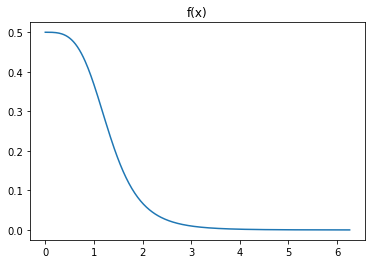

In [2]:
#Visualicemos la funcion
import matplotlib.pyplot as plt
from math import pi

xs = [float(i/50) for i in range(int(50*pi*2))]
ys = [f(x) for x in xs]
plt.plot(xs,ys)
plt.title("f(x)");

## MC Genérico

In [12]:
#Estimemos el valor de la integral usando el metodo por rechazo, usanndo 10000 puntos
from random import uniform
from math import sqrt

N = 10000
lim_inf = 0
lim_sup = 5 #No puedo integrar hasta infinito


in_points = 0
for i in range(N):
    point = (uniform(lim_inf, lim_sup),uniform(0, 1))
    if point[1]<f(point[0]): in_points+=1

#Calculo el valor de la integral
Integral = (lim_sup-lim_inf)*in_points/N
#En wolframalpha se pide asi:
#integrate e^(-1*x))/(1+(x-1)^2) dx from x=0 to 100
print(f"Valor reportado por https://www.wolframalpha.com/ : 0.695811")
print(f"integral:      {Integral:4f} +- {lim_sup*sqrt(Integral)/sqrt(N):4f}")


Valor reportado por https://www.wolframalpha.com/ : 0.695811
integral:      0.684500 +- 0.041367


In [7]:
#Estimemos el valor de la integral usando el metodo generalizado, usanndo 10000 puntos

from random import uniform
from math import sqrt

N = 10000
lim_inf = 0
lim_sup = 5 #No puedo integrar hasta infinito

sum_of_samples = 0
sum_of_samples2 = 0

for i in range(N):
    x = uniform(lim_inf, lim_sup)
    sum_of_samples += f(x)
    sum_of_samples2 += f(x)*f(x)

#Calculo el valor de la integral y el error
Integral2 = (lim_sup - lim_inf) * (sum_of_samples/N)
Int_error2 = (lim_sup - lim_inf) * sqrt((sum_of_samples2/N-(sum_of_samples*sum_of_samples)/(N*N))/N)

print(f"integral:      {Integral2:4f} +- {Int_error2:4f}")
 

integral:      0.702235 +- 0.002922


## MC IS

Para utilizar el método de IS se necesita escoger una función de peso, que siga las condiciones descritas anteriormente y que sea facilmente integrable. Para este caso utilizaremos la siguiente función de peso $ w(x)=Ae^{-x/\lambda}$, pues está distribuida similarmente a la función a integrar. De la condición de unitariedad, tenemos que $A=\frac{1}{\lambda}$. Entonces $w$ queda 

$$ w(x)=\frac{1}{\lambda}e^{-x/\lambda} $$

con $W(x)=1-e^{-x/\lambda}$, con inverza $x=-\lambda \ln(1-W)$. Note que si generamos números con densidad uniforme $W$, tendremos $x$ exponencialmente distribuidos en $(0,\infty)$.


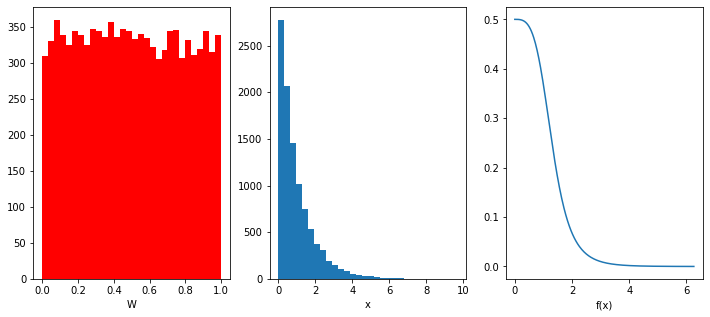

In [8]:
from random import random
from math import log
import matplotlib.pyplot as plt

#Generemos algunos numeros W
N = 10000
lam = 1

in_points = 0
#Almacenamos los puntos
point_W = []
point_x = []

for i in range(N):
    W = random()
    point_W.append(W)
    point_x.append(-lam*log(1-W))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 5))
ax1.hist(point_W, bins = 30,color="r")
ax1.set( xlabel = "W")
ax2.hist(point_x, bins = 30)
ax2.set( xlabel = "x")
ax3.plot(xs,ys)
ax3.set( xlabel = "f(x)")
plt.show()

Ahora podemos usar esta distribución para evaluar en el método de MC,

In [10]:
#Declaramos ahora la funcion pesada
from math import e
def h(lam, x):
    """
    Esta es la función principal con el peso.
    Args:
    - lam (float): parametro lambda
    - x (float)
    Out:
    - salida de la función h(x) (float)
    """
    return lam*f(x)/(e**(-x/lam))

In [11]:
from random import random
from math import log
import matplotlib.pyplot as plt

#Generemos algunos numeros
N = 1000
lam = 1

sum_of_samples = 0
sum_of_samples2 = 0

for i in range(N):
    X = -lam*log(1-random())
    sum_of_samples += h(lam, X)
    sum_of_samples2 += h(lam, X)*h(lam, X)

#Calculo el valor de la integral y el error
Integral3 = (sum_of_samples/N)
Int_error3 = sqrt((sum_of_samples2/N-(sum_of_samples*sum_of_samples)/(N*N))/N)

print(f"integral:      {Integral3:4f} +- {Int_error3:4f}")


integral:      0.697471 +- 0.007259


Podemos ver que con este método el valor de la integral converge con muchas menos iteraciones (un orden de magnitud menos en este ejemplo), que con los métodos anteriores. En principio se puede optimizar la función de peso (parámetro $\lambda$) para que converga más rápido, por medio de optimizar la varianza.

## Método de rechazo para generar muestreo

En algunos casos, invertir la función de peso puede resultar imposible. Luego el método del *rechazo* puede manejar esta situación. La idea es elegir dos variables uniformes $ u_1, u_2 \sim \mathcal{U} [a, b]$ para que 

$$
\mathbb{P}\left(u_1 \in N_{\Delta}(x) \bigwedge u_2 < \frac{f(u_1)}{M} \right) \hspace{0.5em} \approx \frac{\Delta x}{b-a} \frac{f(u_1)}{M}
$$

donde tomamos $x = u_1$ y $f (x)<M$ , con $M$ una constante. Este es un proceso de dos pasos:

- Primero, dibujamos $u_1$ uniformemente del intervalo $ [a, b] $. 
-Segundo, usamos esta variable en $f(x)$ y si $u_2 <f(u_1)/M$, entonces tiene una muestra válida para $f(x)$ . 

Por lo tanto, $u_1$ es la muestra propuesta de $f$ que puede o no ser rechazada según en $u_2$. El único trabajo de la constante $M$ es reducir la escala $f(x)$ para que la variable $u_2$ puede abarcar el rango. La *eficiencia* de este método es la probabilidad de aceptar $ u_1 $ que proviene de integrar lo aproximación anterior, luego

$$
\int \frac{f(x)}{M(b-a)} dx = \frac{1}{M(b-a)} \int f(x)dx =\frac{1}{M(b-a)}
$$

Esto significa que no queremos un $M$ innecesariamente grande porque eso hace que sea más probable que se descarten las muestras.

__Ejemplo:__ 

Probemos este método para una densidad que no tenga una inversa continua. Integremos la siguiente función en el intervalo $[0,15]$

$$
f(x) = \frac{(x+1)}{4} e^{\left(-\frac{2(x-1)^2}{x} \right)}
$$

donde $x<0$

In [13]:
#Definamos la funcion
def f(x): 
    """
    Esta es la función.
    Args:
    - x (float)
    Out:
    - salida de la función f(x) (float)
    """
    
    return np.exp(-2*(x-1)**2/x)*(x+1)/4

[]

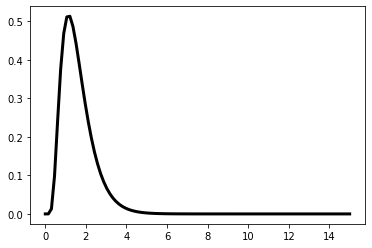

In [16]:
#Usemos la librerian de numeros aleatorios de numpy
import numpy as np

#Genero un vector de 100 componentes linealmente espaciado entre 0 y 15.
# No se puede poner 0 pues sale error, luego uso 0.0001.
x = np.linspace(0.0001,15,100)
fx = f(x)

#Ahora grafiquemos la funcion para escoger M
fig,ax=plt.subplots()
ax.plot(x,fx,'k',lw=3.,label='$f(x)$')
plt.plot()

Viendo que en el rango de la integración la cota suoerior de la función es $0.2$, tomo $M=0.3$.

In [17]:
#Asigno el factor de escala
M=.6                
#Genero numeros aleatorios en el rango
u1 = np.random.uniform(0,15,10000)
# Genero numeros aleatorios para el dominio
u2 = np.random.rand(10000)
# Encuentro las posiciones donde el criterio se cumple
idx = np.where(u2<=f(u1)/M)
# Encuentro las posiciones donde el criterio NO se cumple
idxn = np.where(u2>f(u1)/M)
#Actualizo el vector x (puntos dentro y fuera)
X = u1[idx]
Xn = u1[idxn]

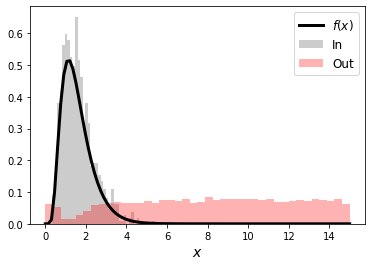

In [19]:
fig,ax=plt.subplots()
ax.hist(X,density=1,bins=40,alpha=.4,color='gray',label='In')
ax.hist(Xn,density=1,bins=40,alpha=.3,color='red',label='Out')
#Todos los puntos los reescalo con M
#ax.plot(u1,M*u2,'k',lw=3.,marker='.',alpha=.05,label='All')
ax.plot(x,fx,'k',lw=3.,label='$f(x)$')
ax.legend(loc=0,fontsize=12)
ax.set_xlabel('$x$',fontsize=14)
#fig.tight_layout()
plt.show()

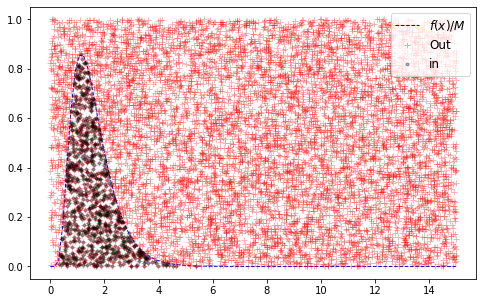

In [20]:
fig,ax=plt.subplots(figsize=(8, 5))
ax.plot(x,fx/M,'blue',linestyle ='--',lw=1.,label='$f(x)/M$')
ax.plot(u1,u2,'+',label='Out',alpha=.3,color='red')
ax.plot(X,u2[idx],'.',label='in',alpha=.3,color='k')
ax.legend(loc=1,fontsize=12)

El método de rechazo usa $u_1$ para seleccionar a lo largo del dominio de $f(x)$ la otra variable aleatoria uniforme $u_2$ . Otra idea sería elegir $u_1$ para que los valores de $x$ sean coincidentemente los que son cerca del pico de $f(x)$, en lugar de uniformemente en cualquier lugar del dominio (como en IS). Ahora, el truco es encontrar función de densidad $g(x)$ para muestrear que tenga una concentración similar de densidad de probabilidad. Explícitamente, lo que queremos es $u_1\sim g(x)$. Lo más sensillo es buscar en las librerías de python por funciones de densidad de probabilidad que tengan un comportamiento similar a la función que se quiere muestrear, si no lo encuentra puede recurrir a este método.

Ejercicio:

Utilizar este método para generar una muestra para integrar:
$$\int_0^{10}dx(x^2-4)$$